In [9]:
%pip install kagglehub
%pip install pymysql sqlalchemy

Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.1 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.1 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.1 MB ? eta -:--:--
   --------- ------------------------------ 0.5/2.1 MB 409.0 kB/s eta 0:00:04
   --------- ------------------------------ 0.5/2.1 MB 409.0 kB/s eta 0:00:04
   -------------- ------------------------- 0.8/2.1 MB 459.5 kB/s eta 0:00:03
   -------------- ------------------------- 0.8/2.1 MB 459.5 kB/s eta 0:00:03
   ------------------- -------------------- 1.0/2.1 MB 529.6 kB/s eta 0:00:03
   ------------------------ --------------- 1.3/2.1 MB 610.0 kB/s eta 0:00:02
   ----------------------------- ---------- 1.6/2.1 MB 693.1 kB/s eta 0:00:01
   ---------------------------------- -----

# **Alasan Pemilihan Topik**


kami memilih topik Analisis E-Commerence terhadap Inflasi Mata Uang Brazil yang memiliki tujuan untuk mengetahui pengaruh inflasi terhadap daya beli penduduk Brazil dengan rentang waktu dari 2016 - 2018. Dataset utama yang digunakan yaitu "olistbr/brazilian-ecommerce" yang kami ambil dari kaggle dan dataset kedua "lucashmateo/brazil-inflation-data" yang juga kami ambil dari kaggle.


In [ ]:
import os
import shutil
import time
import glob
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sqlalchemy import create_engine, text
from datetime import datetime
import pymysql

# **Extract**

In [30]:
LOCAL_BASE_DIR = "C:\\Users\\LENOVO LOQ\\OneDrive - Telkom University\\Documents\\Kuliah\\Tugas dan Materi\\Semester 7\\Big Data\\UAS_BigData"

if not os.path.exists(LOCAL_BASE_DIR):
    os.makedirs(LOCAL_BASE_DIR)

def extract_from_kaggle(source_name, folder_suffix):
    """
    Fungsi untuk download dari Kaggle dan memindahkannya ke folder lokal
    """
    print(f"--- Memulai Ekstraksi: {source_name} ---")
    start_time = time.time()

    try:
        path = kagglehub.dataset_download(source_name)
        print(f"Download selesai di cache: {path}")
    except Exception as e:
        print(f"Gagal download: {e}")
        return

    destination_folder = os.path.join(LOCAL_BASE_DIR, folder_suffix) 
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    files = glob.glob(os.path.join(path, "*.*")) 
    for file in files:
        file_name = os.path.basename(file)
        dest_path = os.path.join(destination_folder, file_name)
        
        if not os.path.exists(dest_path):
            shutil.copy(file, dest_path)
            print(f"Berhasil memindahkan: {file_name}")
        else:
            print(f"File sudah ada: {file_name}")

    print(f"\nVerifikasi Data di: {destination_folder}")
    local_files = glob.glob(os.path.join(destination_folder, "*.csv"))
    
    total_size = 0
    for f in local_files:
        size = os.path.getsize(f) / (1024 * 1024) # MB
        total_size += size
        df_temp = pd.read_csv(f, nrows=5) # Cek header saja
        print(f"- {os.path.basename(f)}: {df_temp.shape[1]} Kolom, Size: {size:.2f} MB")

    print(f"Total Ukuran: {total_size:.2f} MB")
    print(f"Waktu Eksekusi: {time.time() - start_time:.2f} detik\n")
    return destination_folder

path_ecommerce = extract_from_kaggle("olistbr/brazilian-ecommerce", "brazilian-ecommerce")
path_inflation = extract_from_kaggle("lucashmateo/brazil-inflation-data", "brazil-inflation-data")

--- Memulai Ekstraksi: olistbr/brazilian-ecommerce ---
Download selesai di cache: C:\Users\LENOVO LOQ\.cache\kagglehub\datasets\olistbr\brazilian-ecommerce\versions\2
File sudah ada: olist_customers_dataset.csv
File sudah ada: olist_geolocation_dataset.csv
File sudah ada: olist_orders_dataset.csv
File sudah ada: olist_order_items_dataset.csv
File sudah ada: olist_order_payments_dataset.csv
File sudah ada: olist_order_reviews_dataset.csv
File sudah ada: olist_products_dataset.csv
File sudah ada: olist_sellers_dataset.csv
File sudah ada: product_category_name_translation.csv

Verifikasi Data di: C:\Users\LENOVO LOQ\OneDrive - Telkom University\Documents\Kuliah\Tugas dan Materi\Semester 7\Big Data\UAS_BigData\brazilian-ecommerce
- brazil.inflation.monthly (statbureau.org).csv: 14 Kolom, Size: 0.00 MB
- olist_customers_dataset.csv: 5 Kolom, Size: 8.62 MB
- olist_geolocation_dataset.csv: 5 Kolom, Size: 58.44 MB
- olist_orders_dataset.csv: 8 Kolom, Size: 16.84 MB
- olist_order_items_dataset.

# **Transform**

 Fitur price_norm dibentuk menggunakan metode Min-Max Scaling untuk menormalisasi harga ke rentang 0–1, sehingga memudahkan perbandingan antar produk dan mendukung analisis maupun pemodelan yang sensitif terhadap skala data.
 fitur delivery_days yang merepresentasikan durasi pengiriman dalam satuan hari berdasarkan selisih antara tanggal pembelian dan tanggal pengiriman, dengan pembatasan nilai agar tidak negatif.

Penggunaan Metode Interquartile Range (IQR) dilakukan untuk penanganan outlier, IQR bersifat robust terhadap distribusi data yang tidak normal dan nilai ekstrem (umum terjadi data pada e-commerence). IQR hanya bergantung pada kuartil bawah (Q1) dan atas (Q3) sehingga tak terpengaruh secara signifikan oleh nilai yang sangat besar/kecil. hal ini membuat IQR menjadi lebih stabil dibandingkan model lainnya untuk dataset e-commerence.

Source 1: Memuat dataset...

SOURCE 1: LAPORAN SEBELUM TRANSFORMASI
Total Baris: 112650
Total Kolom: 26

[1] Missing Values per Kolom:
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
product_category_name            1603
product_name_lenght              1603
product_description_lenght       1603
product_photos_qty               1603
product_weight_g                   18
product_length_cm                  18
product_height_cm                  18
product_width_cm                   18
dtype: int64

[2] Cek Duplikasi:
Baris duplikat penuh: 0
Duplikat Primary Key (order_id, order_item_id): 0

[3] Menampilkan Visualisasi Boxplot...


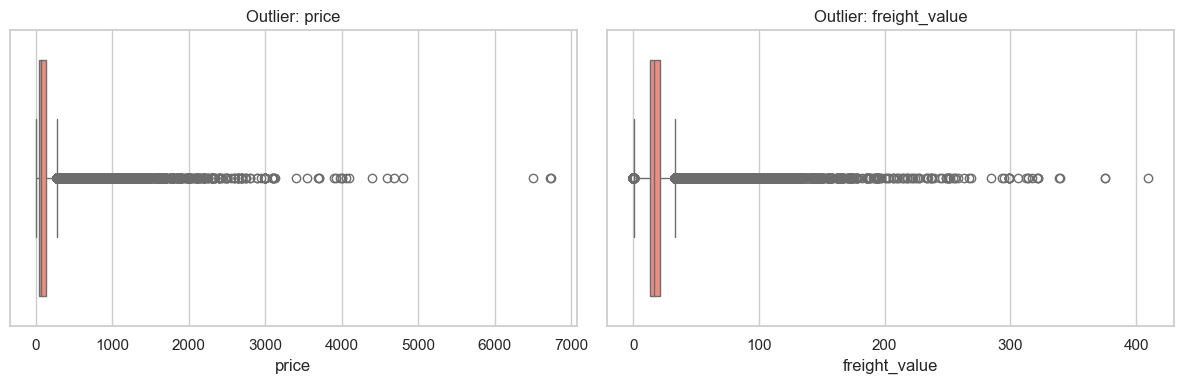


[4] Statistik Deskriptif Outlier (IQR):
- Kolom 'price': Terdeteksi 8427 outliers (7.48%)
- Kolom 'freight_value': Terdeteksi 12134 outliers (10.77%)

MEMULAI PROSES TRANSFORMASI (CLEANING & ENGINEERING)

Transformasi Selesai.

SOURCE 1: LAPORAN SESUDAH TRANSFORMASI
Total Baris: 112650
Total Kolom: 33

[1] Missing Values per Kolom:
order_approved_at    15
dtype: int64

[2] Cek Duplikasi:
Baris duplikat penuh: 0
Duplikat Primary Key (order_id, order_item_id): 0

[3] Menampilkan Visualisasi Boxplot...


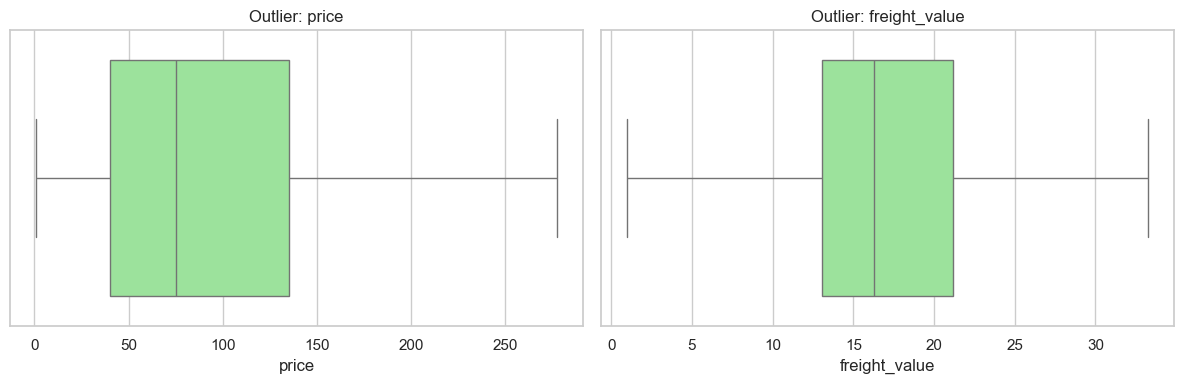


[4] Statistik Deskriptif Outlier (IQR):
- Kolom 'price': Terdeteksi 0 outliers (0.0%)
- Kolom 'freight_value': Terdeteksi 0 outliers (0.0%)

TAHAP 5: VALIDASI KUALITAS DATA
1. Uniqueness (Order Key)      : PASSED
2. Null Check (Critical Cols)  : PASSED
3. Range Check (Price >= 0)    : PASSED
4. Datatype (Timestamp)        : PASSED
5. Referential Integrity       : PASSED
6. Distribution (Price Skew)   : 1.09 (Normal Range: -2 to 2)


In [ ]:
sns.set_theme(style="whitegrid")

class OlistTransformer:
    def __init__(self, raw_path):
        self.raw_path = raw_path
        self.df = None
        self.df_raw = None
        self.quality_report = {}

    def load_and_merge_internal(self):
        print("Source 1: Memuat dataset...")
        orders = pd.read_csv(os.path.join(self.raw_path, 'olist_orders_dataset.csv'))
        items = pd.read_csv(os.path.join(self.raw_path, 'olist_order_items_dataset.csv'))
        cust = pd.read_csv(os.path.join(self.raw_path, 'olist_customers_dataset.csv'))
        prod = pd.read_csv(os.path.join(self.raw_path, 'olist_products_dataset.csv'))

        df = items.merge(orders, on='order_id', how='left')
        df = df.merge(cust, on='customer_id', how='left')
        self.df_raw = df.merge(prod, on='product_id', how='left')
        self.df = self.df_raw.copy()
        return self.df

    def _generate_detailed_report(self, df, title, color):
        print("\n" + "="*60)
        print(f"{title}")
        print("="*60)
        print(f"Total Baris: {df.shape[0]}")
        print(f"Total Kolom: {df.shape[1]}")

     
        print("\n[1] Missing Values per Kolom:")
        missing = df.isnull().sum()
        if missing.sum() > 0:
            print(missing[missing > 0])
        else:
            print("Tidak ada missing value.")

   
        print("\n[2] Cek Duplikasi:")
        print(f"Baris duplikat penuh: {df.duplicated().sum()}")
        pk_cols = ['order_id', 'order_item_id']
        if all(col in df.columns for col in pk_cols):
             print(f"Duplikat Primary Key (order_id, order_item_id): {df.duplicated(subset=pk_cols).sum()}")

        
        num_cols = ['price', 'freight_value']
        print("\n[3] Menampilkan Visualisasi Boxplot...")
        plt.figure(figsize=(12, 4))
        for i, col in enumerate(num_cols):
            if col in df.columns:
                plt.subplot(1, 2, i+1)
                sns.boxplot(data=df, x=col, color=color)
                plt.title(f"Outlier: {col}")
        plt.tight_layout()
        plt.show()

       
        print("\n[4] Statistik Deskriptif Outlier (IQR):")
        for col in num_cols:
            if col in df.columns:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
                print(f"- Kolom '{col}': Terdeteksi {len(outliers)} outliers ({round(len(outliers)/len(df)*100, 2)}%)")

    def pre_transformation_report(self):
        self._generate_detailed_report(self.df_raw, "SOURCE 1: LAPORAN SEBELUM TRANSFORMASI", "salmon")

    def transform_pipeline(self):
            print("\n" + "="*60)
            print("MEMULAI PROSES TRANSFORMASI (CLEANING & ENGINEERING)")
            print("="*60)

      
            self.df.drop_duplicates(subset=['order_id', 'order_item_id'], inplace=True)
            date_cols = ['order_purchase_timestamp', 'order_delivered_customer_date',
                        'order_estimated_delivery_date', 'order_approved_at']
            for col in date_cols:
                self.df[col] = pd.to_datetime(self.df[col], errors='coerce')

        
            self.df['order_delivered_customer_date'] = self.df['order_delivered_customer_date'].fillna(self.df['order_estimated_delivery_date'])

          
            num_cols_list = self.df.select_dtypes(include=[np.number]).columns
            self.df[num_cols_list] = self.df[num_cols_list].fillna(self.df[num_cols_list].median())
            obj_cols_list = self.df.select_dtypes(include=['object']).columns
            self.df[obj_cols_list] = self.df[obj_cols_list].fillna("Unknown")

        
            for col in ['price', 'freight_value']:
                Q1 = self.df[col].quantile(0.25)
                Q3 = self.df[col].quantile(0.75)
                IQR = Q3 - Q1
                self.df[col] = np.clip(self.df[col], Q1 - 1.5*IQR, Q3 + 1.5*IQR)

         
            self.df.columns = [c.lower().strip().replace(' ', '_') for c in self.df.columns]
            self.df['delivery_days'] = (self.df['order_delivered_customer_date'] - self.df['order_purchase_timestamp']).dt.days.clip(lower=0)
            self.df['total_order_value'] = self.df['price'] + self.df['freight_value']
            self.df['is_late'] = (self.df['order_delivered_customer_date'] > self.df['order_estimated_delivery_date']).astype(int)
            self.df['purchase_hour'] = self.df['order_purchase_timestamp'].dt.hour
            self.df['freight_ratio'] = self.df['freight_value'] / (self.df['price'] + 0.001) # +0.001 menghindari division by zero

            scaler = MinMaxScaler()
            self.df[['price_norm', 'freight_norm']] = scaler.fit_transform(self.df[['price', 'freight_value']])

            print("\nTransformasi Selesai.")
            return self.df

    def validate_quality_data(self):
            print("\n" + "="*60)
            print("TAHAP 5: VALIDASI KUALITAS DATA")
            print("="*60)

            unique_check = self.df.duplicated(subset=['order_id', 'order_item_id']).sum() == 0
            null_check = self.df[['order_id', 'price', 'customer_id']].isnull().sum().sum() == 0
            range_check = (self.df['price'] >= 0).all() and (self.df['freight_value'] >= 0).all()
            is_datetime = pd.api.types.is_datetime64_any_dtype(self.df['order_purchase_timestamp'])
            ref_integrity = self.df['customer_id'].notnull().all()
            price_skew = self.df['price'].skew()
          
            self.quality_report = {
                "1. Uniqueness (Order Key)": "PASSED" if unique_check else "FAILED",
                "2. Null Check (Critical Cols)": "PASSED" if null_check else "FAILED",
                "3. Range Check (Price >= 0)": "PASSED" if range_check else "FAILED",
                "4. Datatype (Timestamp)": "PASSED" if is_datetime else "FAILED",
                "5. Referential Integrity": "PASSED" if ref_integrity else "FAILED",
                "6. Distribution (Price Skew)": f"{price_skew:.2f} (Normal Range: -2 to 2)"
            }

            for rule, status in self.quality_report.items():
                print(f"{rule:<30} : {status}")
          
            return self.quality_report

    def post_transformation_report(self):
        self._generate_detailed_report(self.df, "SOURCE 1: LAPORAN SESUDAH TRANSFORMASI", "lightgreen")

path_s1 = "C:\\Users\\LENOVO LOQ\\OneDrive - Telkom University\\Documents\\Kuliah\\Tugas dan Materi\\Semester 7\\git\\bigdata\\bigdata_final_project\\raw"
trans1 = OlistTransformer(path_s1)
trans1.load_and_merge_internal()
trans1.pre_transformation_report()
df_s1_final = trans1.transform_pipeline()
trans1.post_transformation_report()
trans1.validate_quality_data()
df_s1_final.to_csv('C:\\Users\\LENOVO LOQ\\OneDrive - Telkom University\\Documents\\Kuliah\\Tugas dan Materi\\Semester 7\\git\\bigdata\\bigdata_final_project\\warehouse\\etl\\transformed_source1_brazilian_ecommerce.csv', index=False)

Feature enrichment pada proses transformasi data inflasi dilakukan untuk mengekstraksi informasi tambahan dari data inflasi bulanan sehingga dapat merepresentasikan kondisi ekonomi tahunan secara lebih komprehensif. Dari data inflasi bulanan Januari hingga Desember, dibentuk beberapa fitur agregat tahunan:
- yearly_avg sebagai rata-rata inflasi tahunan yang mencerminkan tingkat inflasi umum dalam satu tahun 
- yearly_max sebagai nilai inflasi bulanan tertinggi yang merepresentasikan tekanan inflasi maksimum 
- yearly_std yang menunjukkan tingkat volatilitas inflasi sepanjang tahun.

 Berdasarkan nilai standar deviasi tersebut, dibuat fitur biner is_volatile untuk mengklasifikasikan tahun dengan fluktuasi inflasi tinggi. Selain itu, fitur year_trend_diff dibentuk dari selisih inflasi bulan Desember dan Januari untuk menggambarkan tren perubahan inflasi dalam satu tahun. Untuk mendukung analisis risiko, rata-rata inflasi tahunan juga dikonversi menjadi kategori inflation_risk (Low, Medium, High) dan selanjutnya dienkode secara numerik melalui risk_encoded, sehingga dapat digunakan dalam analisis kuantitatif.

[INFO] Source 2: Memuat dataset inflasi...

SOURCE 2: LAPORAN SEBELUM TRANSFORMASI
Total Baris: 40 | Total Kolom: 13

[1] Missing Values per Kolom:
February     1
March        1
April        1
May          1
June         1
July         1
August       1
September    1
October      1
November     1
December     1
dtype: int64

[2] Cek Duplikasi:
Baris duplikat penuh: 0
Duplikat Primary Key (Year): 0

[3] Menampilkan Visualisasi Boxplot (Seluruh Bulan)...


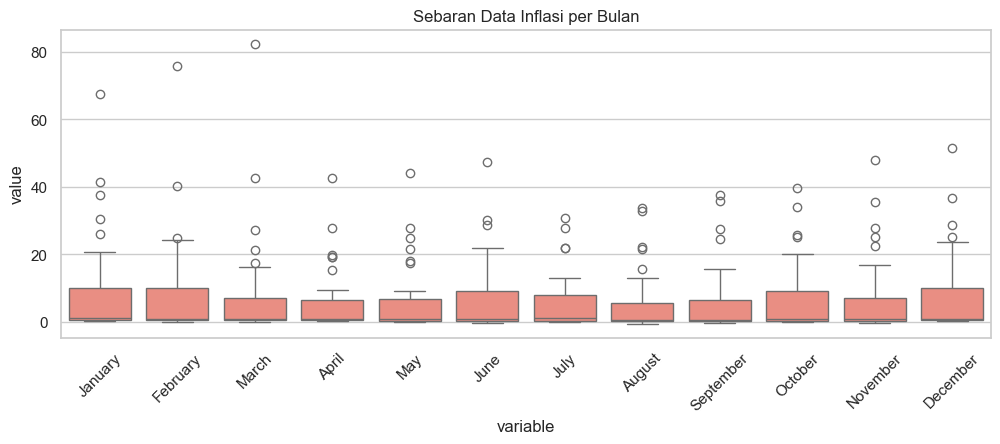


[4] Statistik Deskriptif Outlier (IQR) - Sampel Januari & Juli:
- Kolom 'January': Terdeteksi 5 outliers (12.5%)
- Kolom 'July': Terdeteksi 4 outliers (10.0%)

MEMULAI PROSES TRANSFORMASI (CLEANING & ENGINEERING)

Transformasi Selesai.

SOURCE 2: LAPORAN SESUDAH TRANSFORMASI
Total Baris: 40 | Total Kolom: 20

[1] Missing Values per Kolom:
Tidak ada missing value.

[2] Cek Duplikasi:
Baris duplikat penuh: 0
Duplikat Primary Key (year): 0

[3] Menampilkan Visualisasi Boxplot (Seluruh Bulan)...


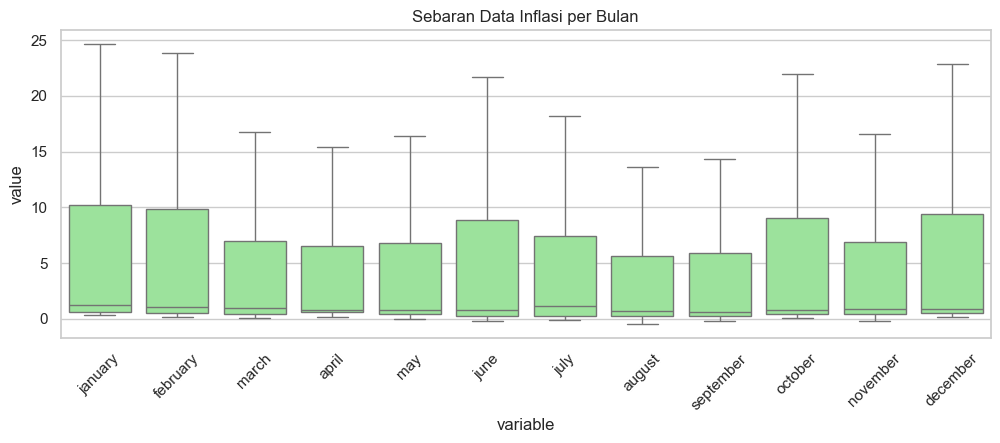


[4] Statistik Deskriptif Outlier (IQR) - Sampel Januari & Juli:
- Kolom 'january': Terdeteksi 0 outliers (0.0%)
- Kolom 'july': Terdeteksi 0 outliers (0.0%)

TAHAP 5: VALIDASI KUALITAS DATA SOURCE 2
1. Uniqueness (Year)                : PASSED
2. Null Check (Total)               : PASSED
3. Range Check (Year >= 1980)       : PASSED
4. Datatype (Numeric Rate)          : PASSED
5. Referential Integrity            : PASSED
6. Distribution (Yearly Avg Skew)   : 1.15


In [ ]:
sns.set_theme(style="whitegrid")

class InflationTransformer:
    def __init__(self, raw_path):
        self.raw_path = raw_path
        self.df = None
        self.df_raw = None
        self.months = ['January', 'February', 'March', 'April', 'May', 'June',
                       'July', 'August', 'September', 'October', 'November', 'December']
        self.quality_report = {}

    def load_data(self):
        """[C.1] Memuat data inflasi Brasil"""
        print("[INFO] Source 2: Memuat dataset inflasi...")
        file_path = os.path.join(self.raw_path, 'brazil.inflation.monthly (statbureau.org).csv')

        self.df_raw = pd.read_csv(file_path)
        self.df_raw.columns = self.df_raw.columns.str.strip()

        if 'Total' in self.df_raw.columns:
            self.df_raw = self.df_raw.drop(columns=['Total'])

        self.df = self.df_raw.copy()
        return self.df

    def _generate_detailed_report(self, df, title, color):
        print("\n" + "="*60)
        print(f"{title}")
        print("="*60)
        print(f"Total Baris: {df.shape[0]} | Total Kolom: {df.shape[1]}")

        # 1. Missing Values per Kolom
        print("\n[1] Missing Values per Kolom:")
        missing = df.isnull().sum()
        if missing.sum() > 0:
            print(missing[missing > 0])
        else:
            print("Tidak ada missing value.")

        # 2. Cek Duplikasi
        print("\n[2] Cek Duplikasi:")
        print(f"Baris duplikat penuh: {df.duplicated().sum()}")
        year_pk_col = 'Year' if 'Year' in df.columns else 'year'
        if year_pk_col in df.columns:
            print(f"Duplikat Primary Key ({year_pk_col}): {df.duplicated(subset=[year_pk_col]).sum()}")

        # 3. Visualisasi Outlier
        print("\n[3] Menampilkan Visualisasi Boxplot (Seluruh Bulan)...")
        plt.figure(figsize=(12, 4))
        current_month_cols = [m for m in self.months if m in df.columns]
        if not current_month_cols:
            current_month_cols = [m.lower() for m in self.months if m.lower() in df.columns]
        
        if year_pk_col in df.columns and current_month_cols:
            df_plot = df.melt(id_vars=[year_pk_col], value_vars=current_month_cols)
            sns.boxplot(data=df_plot, x='variable', y='value', color=color)
            plt.title(f"Sebaran Data Inflasi per Bulan")
            plt.xticks(rotation=45)
            plt.show()

        # 4. Statistik Deskriptif Outlier (IQR)
        print("\n[4] Statistik Deskriptif Outlier (IQR) - Sampel Januari & Juli:")
        sample_cols = ['January', 'July'] if 'January' in df.columns else ['january', 'july']
        for col in sample_cols:
            if col in df.columns:
                Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
                IQR = Q3 - Q1
                outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
                print(f"- Kolom '{col}': Terdeteksi {len(outliers)} outliers ({round(len(outliers)/len(df)*100, 2)}%)")

    def pre_transformation_report(self):
        self._generate_detailed_report(self.df_raw, "SOURCE 2: LAPORAN SEBELUM TRANSFORMASI", "salmon")

    def transform_pipeline(self):
        print("\n" + "="*60)
        print("MEMULAI PROSES TRANSFORMASI (CLEANING & ENGINEERING)")
        print("="*60)

        self.df.drop_duplicates(subset=['Year'] if 'Year' in self.df.columns else ['year'], inplace=True)
        for month in self.months:
            if month in self.df.columns:
                self.df[month] = self.df[month].fillna(self.df[month].median())
                Q1, Q3 = self.df[month].quantile(0.25), self.df[month].quantile(0.75)
                IQR = Q3 - Q1
                self.df[month] = np.clip(self.df[month], Q1 - 1.5*IQR, Q3 + 1.5*IQR)
        self.df.columns = [c.lower().strip() for c in self.df.columns]
        scaler = MinMaxScaler()
        self.df[['january_norm', 'december_norm']] = scaler.fit_transform(self.df[['january', 'december']])

        month_cols = [m.lower() for m in self.months]
        self.df['yearly_avg'] = self.df[month_cols].mean(axis=1)
        self.df['yearly_max'] = self.df[month_cols].max(axis=1)
        self.df['yearly_std'] = self.df[month_cols].std(axis=1)
        self.df['is_volatile'] = (self.df['yearly_std'] > 0.5).astype(int)
        self.df['year_trend_diff'] = self.df['december'] - self.df['january']

        print("\nTransformasi Selesai.")
        return self.df

    def validate_quality_data(self):
        print("\n" + "="*60)
        print("TAHAP 5: VALIDASI KUALITAS DATA SOURCE 2")
        print("="*60)

        unique_check = self.df['year'].is_unique
        null_check = self.df.isnull().sum().sum() == 0
        range_check = (self.df['year'] >= 1980).all()
        dtype_check = pd.api.types.is_numeric_dtype(self.df['january'])
        ref_integrity = self.df['year'].notnull().all()
        skew_val = self.df['yearly_avg'].skew()

        self.quality_report = {
            "1. Uniqueness (Year)": "PASSED" if unique_check else "FAILED",
            "2. Null Check (Total)": "PASSED" if null_check else "FAILED",
            "3. Range Check (Year >= 1980)": "PASSED" if range_check else "FAILED",
            "4. Datatype (Numeric Rate)": "PASSED" if dtype_check else "FAILED",
            "5. Referential Integrity": "PASSED" if ref_integrity else "FAILED",
            "6. Distribution (Yearly Avg Skew)": f"{skew_val:.2f}"
        }

        for rule, status in self.quality_report.items():
            print(f"{rule:<35} : {status}")

    def post_transformation_report(self):
        original_months = self.months.copy()
        self.months = [m.lower() for m in self.months]
        self._generate_detailed_report(self.df, "SOURCE 2: LAPORAN SESUDAH TRANSFORMASI", "lightgreen")
        self.months = original_months

path_s2 = "C:\\Users\\LENOVO LOQ\\OneDrive - Telkom University\\Documents\\Kuliah\\Tugas dan Materi\\Semester 7\\git\\bigdata\\bigdata_final_project\\raw"
trans2 = InflationTransformer(path_s2)
trans2.load_data()
trans2.pre_transformation_report()
df_s2_final = trans2.transform_pipeline()
trans2.post_transformation_report()

trans2.validate_quality_data()

df_s2_final.to_csv('C:\\Users\\LENOVO LOQ\\OneDrive - Telkom University\\Documents\\Kuliah\\Tugas dan Materi\\Semester 7\\git\\bigdata\\bigdata_final_project\\warehouse\\etl\\transformed_source2_brazil_inflation.csv', index=False)

# **Load**

In [ ]:
DB_USER = 'root'
DB_PASS = ''
DB_HOST = 'localhost'
DB_PORT = '3306'
DB_NAME = 'olist_dw'

def log_process(message):
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {message}")

def main():
    log_process("Memulai Proses ETL Load di Local...")

    try:
        file_ecommerce = 'transformed_source1_brazilian_ecommerce.csv'
        file_inflation = 'transformed_source2_brazil_inflation.csv'

        if not os.path.exists(file_ecommerce):
            raise FileNotFoundError(f"File '{file_ecommerce}' tidak ditemukan!")
        if not os.path.exists(file_inflation):
            raise FileNotFoundError(f"File '{file_inflation}' tidak ditemukan!")
            
        df_ecommerce = pd.read_csv(file_ecommerce)
        df_inflation_wide = pd.read_csv(file_inflation)
        log_process("Berhasil membaca file CSV.")
    except Exception as e:
        log_process(f"Error Membaca File: {e}")
        return

    try:
        month_map = {
            'january': 1, 'february': 2, 'march': 3, 'april': 4, 'may': 5, 'june': 6,
            'july': 7, 'august': 8, 'september': 9, 'october': 10, 'november': 11, 'december': 12
        }
        
        cols_to_melt = [c for c in df_inflation_wide.columns if c in month_map.keys()]
        id_vars = ['year']
        if 'yearly_avg' in df_inflation_wide.columns: id_vars.append('yearly_avg')
        if 'is_volatile' in df_inflation_wide.columns: id_vars.append('is_volatile')
        if 'inflation_risk' in df_inflation_wide.columns: id_vars.append('inflation_risk')

        df_inflation_long = df_inflation_wide.melt(
            id_vars=id_vars, 
            value_vars=cols_to_melt, 
            var_name='month_name', 
            value_name='inflation_rate'
        )
        
        df_inflation_long['month_num'] = df_inflation_long['month_name'].map(month_map)
        
        df_inflation_long['year_month'] = pd.to_datetime(
            df_inflation_long['year'].astype(str) + '-' + df_inflation_long['month_num'].astype(str) + '-01'
        ).dt.strftime('%Y-%m')
        final_cols = ['year_month', 'inflation_rate'] + [c for c in id_vars if c != 'year']
        
        dim_inflation = df_inflation_long[final_cols].dropna(subset=['inflation_rate']).drop_duplicates('year_month')
        log_process("Persiapan Dimensi Inflasi (dengan fitur baru) selesai.")
    except Exception as e:
        log_process(f"Error Transformasi Inflasi: {e}")
        return


    try:
        dim_customer = df_ecommerce[['customer_id', 'customer_unique_id', 'customer_city', 'customer_state']].drop_duplicates('customer_id')
        if 'product_category_name' in df_ecommerce.columns:
            dim_product = df_ecommerce[['product_id', 'product_category_name']].drop_duplicates('product_id')
        else:
            dim_product = df_ecommerce[['product_id']].drop_duplicates()
            dim_product['product_category_name'] = 'Unknown'

        fact_sales = df_ecommerce.copy()
        fact_sales['order_purchase_timestamp'] = pd.to_datetime(fact_sales['order_purchase_timestamp'])
        
        fact_sales['year_month'] = fact_sales['order_purchase_timestamp'].dt.strftime('%Y-%m')
        
        fact_cols = [
            'order_id', 
            'order_item_id', 
            'customer_id', 
            'product_id', 
            'order_purchase_timestamp', 
            'price', 
            'freight_value', 
            'order_status', 
            'year_month',
            'delivery_days',      
            'total_order_value',  
            'is_late',           
            'purchase_hour',      
            'freight_ratio'       
        ]

        valid_fact_cols = [c for c in fact_cols if c in fact_sales.columns]
        fact_sales = fact_sales[valid_fact_cols]
        
    except Exception as e:
        log_process(f"Error Persiapan Dataframe: {e}")
        return

    connection_str = f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}"
    
    try:
        engine_root = create_engine(connection_str)
        with engine_root.connect() as conn:
            conn.execute(text(f"CREATE DATABASE IF NOT EXISTS {DB_NAME}"))
            conn.execute(text(f"USE {DB_NAME}"))
            conn.execute(text("SET FOREIGN_KEY_CHECKS=0;"))
            
            # Drop tabel lama
            conn.execute(text("DROP TABLE IF EXISTS Fact_Sales"))
            conn.execute(text("DROP TABLE IF EXISTS Dim_Product"))
            conn.execute(text("DROP TABLE IF EXISTS Dim_Customer"))
            conn.execute(text("DROP TABLE IF EXISTS Dim_Inflation"))

            log_process("Membuat Tabel dengan Schema Baru...")
            
            # 1. Dim Customer
            conn.execute(text("""
                CREATE TABLE Dim_Customer (
                    `customer_id` VARCHAR(50) PRIMARY KEY,
                    `customer_unique_id` VARCHAR(50),
                    `customer_city` VARCHAR(100),
                    `customer_state` VARCHAR(5)
                )
            """))
            
            # 2. Dim Product
            conn.execute(text("""
                CREATE TABLE Dim_Product (
                    `product_id` VARCHAR(50) PRIMARY KEY,
                    `product_category_name` VARCHAR(100)
                )
            """))
            
            # 3. Dim Inflation (UPDATE: Menambah kolom yearly_avg & is_volatile)
            conn.execute(text("""
                CREATE TABLE Dim_Inflation (
                    `year_month` VARCHAR(10) PRIMARY KEY,
                    `inflation_rate` FLOAT,
                    `yearly_avg` FLOAT,
                    `is_volatile` INT
                )
            """))
            
            # 4. Fact Sales (UPDATE: Menambah kolom fitur engineering)
            conn.execute(text("""
                CREATE TABLE Fact_Sales (
                    `order_id` VARCHAR(50),
                    `order_item_id` INT,
                    `customer_id` VARCHAR(50),
                    `product_id` VARCHAR(50),
                    `order_purchase_timestamp` DATETIME,
                    `price` FLOAT,
                    `freight_value` FLOAT,
                    `order_status` VARCHAR(50),
                    `year_month` VARCHAR(10),
                    
                    `delivery_days` INT,
                    `total_order_value` FLOAT,
                    `is_late` INT,
                    `purchase_hour` INT,
                    `freight_ratio` FLOAT,
                    
                    PRIMARY KEY (`order_id`, `order_item_id`),
                    FOREIGN KEY (`customer_id`) REFERENCES Dim_Customer(`customer_id`),
                    FOREIGN KEY (`product_id`) REFERENCES Dim_Product(`product_id`),
                    FOREIGN KEY (`year_month`) REFERENCES Dim_Inflation(`year_month`)
                )
            """))
            conn.execute(text("SET FOREIGN_KEY_CHECKS=1;"))
            log_process("Skema Database Berhasil Dibuat.")

        engine_db = create_engine(f"{connection_str}/{DB_NAME}")
        
        log_process("Sedang memuat data ke MySQL...")
        
        # Load Data
        dim_customer.to_sql('Dim_Customer', engine_db, if_exists='append', index=False, chunksize=10000)
        dim_product.to_sql('Dim_Product', engine_db, if_exists='append', index=False, chunksize=10000)
        dim_inflation.to_sql('Dim_Inflation', engine_db, if_exists='append', index=False, chunksize=10000)
        fact_sales.to_sql('Fact_Sales', engine_db, if_exists='append', index=False, chunksize=10000)

        log_process("SUKSES! Semua data beserta fitur baru berhasil dimuat.")
        
    except Exception as e:
        log_process(f"TERJADI ERROR PADA DATABASE: {e}")
        # import traceback
        # traceback.print_exc()
        print("\nSaran: Periksa username, password, dan apakah MySQL Server sudah berjalan.")

if __name__ == "__main__":
    main()

[2025-12-24 14:57:48] Memulai Proses ETL Load di Local...
[2025-12-24 14:57:49] Berhasil membaca file CSV.
[2025-12-24 14:57:49] Persiapan Dimensi Inflasi (dengan fitur baru) selesai.
[2025-12-24 14:57:49] Membuat Tabel dengan Schema Baru...
[2025-12-24 14:57:49] Skema Database Berhasil Dibuat.
[2025-12-24 14:57:49] Sedang memuat data ke MySQL...


C:\Users\LENOVO LOQ\AppData\Local\Temp\ipykernel_74284\1963468092.py:201: UserWarning: The provided table name 'Dim_Customer' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  dim_customer.to_sql('Dim_Customer', engine_db, if_exists='append', index=False, chunksize=10000)
C:\Users\LENOVO LOQ\AppData\Local\Temp\ipykernel_74284\1963468092.py:202: UserWarning: The provided table name 'Dim_Product' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  dim_product.to_sql('Dim_Product', engine_db, if_exists='append', index=False, chunksize=10000)
C:\Users\LENOVO LOQ\AppData\Local\Temp\ipykernel_74284\1963468092.py:203: UserWarning: The provided table name 'Dim_Inflation' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using 

[2025-12-24 14:58:39] SUKSES! Semua data beserta fitur baru berhasil dimuat.


C:\Users\LENOVO LOQ\AppData\Local\Temp\ipykernel_74284\1963468092.py:204: UserWarning: The provided table name 'Fact_Sales' is not found exactly as such in the database after writing the table, possibly due to case sensitivity issues. Consider using lower case table names.
  fact_sales.to_sql('Fact_Sales', engine_db, if_exists='append', index=False, chunksize=10000)
